<a href="https://colab.research.google.com/github/abs-git/GNN/blob/main/Twitch_gamers_language_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch
torch.manual_seed(42)

from IPython.display import clear_output 
torch_version = torch.__version__
print("Torch version: ", torch_version)
pytorch_version = f"torch-{torch.__version__}.html"
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/$pytorch_version
!pip install torch-geometric
clear_output()

## Data load

In [5]:
# streamer - streamer networks

from torch_geometric.datasets import Twitch

twitch_dataset = Twitch(root='.', name='EN')
twitch_dataset2 = Twitch(root='.', name='FR')

print(twitch_dataset[0])
print(twitch_dataset2[0])

Data(x=[7126, 128], edge_index=[2, 77774], y=[7126])
Data(x=[6551, 128], edge_index=[2, 231883], y=[6551])


In [6]:
data = twitch_dataset[0]

In [7]:
# node : twitch gamer
# edge : followerships between gamers
# node feature : playing game, liked game, location, streaming habits
# y : explicited language (1, 0)


print(data.x)
print()
print(data.edge_index)
print()
print(data.y)

tensor([[-0.2367, -0.2307, -0.1605,  ...,  1.3203, -0.2558, -0.1839],
        [-0.2367, -0.2150, -0.1605,  ...,  1.3572, -0.2538, -0.1685],
        [-0.2367, -0.2043, -0.0994,  ..., -0.6348, -0.2558, -0.1839],
        ...,
        [-0.2193, -0.2307, -0.1605,  ..., -0.6348, -0.2558, -0.1839],
        [-0.2367, -0.2307, -0.1605,  ..., -0.6348, -0.2558, -0.1733],
        [ 4.6088, -0.2307, -0.1605,  ...,  1.2370, -0.2558, -0.1839]])

tensor([[6194,  255, 6194,  ..., 7123, 7124, 7125],
        [ 255, 6194,  980,  ..., 7123, 7124, 7125]])

tensor([1, 0, 1,  ..., 0, 0, 1])


In [9]:
import pandas as pd

col = ['target']

df = pd.DataFrame(columns = col)
df['target'] = data.y

df['target'].value_counts()

1    3888
0    3238
Name: target, dtype: int64

## Model

In [76]:
import torch.nn.functional as F

from torch import nn
from torch_geometric.nn import GATConv

class GNN(nn.Module):
  def __init__(self, data, embedding_size):
    super(GNN, self).__init__()

    self.conv1 = GATConv(data.num_features, embedding_size)
    self.conv2 = GATConv(embedding_size, embedding_size)
    self.conv3 = GATConv(embedding_size, embedding_size)

    self.lin = nn.Linear(embedding_size, 1)

  def forward(self, x, edge_index):
    embe = self.conv1(x, edge_index)
    embe = F.relu(embe)
    embe = self.conv2(embe, edge_index)
    embe = F.relu(embe)
    embe = self.conv3(embe, edge_index)
    embe = F.relu(embe)

    out = self.lin(embe)
    return out


In [77]:
embedding_size = 128

model = GNN(data, embedding_size)

nParameters = sum(p.numel() for p in model.parameters())

print(model)
print()
print("nParameters : {}".format(nParameters))

GNN(
  (conv1): GATConv(128, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)

nParameters : 50433


In [78]:
# data split 6:4
# train_mask = train set
# test_mask = test set

from torch.utils.data.dataset import random_split

nNodes = data.x.shape[0]

train_mask = torch.zeros(nNodes, dtype = torch.bool)
test_mask = torch.zeros(nNodes, dtype = torch.bool)

train_ratio = 0.6
train_size = int(nNodes * train_ratio)
test_size = nNodes - train_size

train_mask_idx, test_mask_idx = random_split(data.y, [train_size, test_size])

# print(train_mask_idx.indices)
# print(test_mask_idx.indices)
# print()

train_mask[train_mask_idx.indices] = True
test_mask[test_mask_idx.indices] = True

data.train_mask = train_mask
data.test_mask = test_mask

print(data.train_mask)
print(data.test_mask)

tensor([ True,  True, False,  ...,  True, False, False])
tensor([False, False,  True,  ..., False,  True,  True])


## Experiment

- 하나의 그래프 내 노드 수준 학습을 진행하기 때문에 모든 노드가 학습에 참여한다.
- 여러개의 그래프가 있는 데이터의 경우 GraphSAGE를 적용한다.

In [79]:
def trainer(data, model, optimizer, criterion):
  
  model.train()
  optimizer.zero_grad()

  output = model(data.x, data.edge_index)
  # print(output.shape)

  preds = output[data.train_mask]
  # print(preds.shape)

  targets = data.y[data.train_mask]  
  targets = torch.unsqueeze(targets, dim = -1)
  # print(targets.shape)

  loss = criterion(preds.float(), targets.float())

  loss.backward()
  optimizer.step()

  return loss


def tester(data, model, criterion):
  model.eval()

  output = model(data.x, data.edge_index)

  preds = output[data.test_mask]
  targets = data.y[data.test_mask]
  targets = torch.unsqueeze(targets, dim = -1)

  loss = criterion(preds.float(), targets.float())

  return loss


In [84]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = data.to(device)
embedding_size = 128

model = GNN(data, embedding_size)
model = model.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCEWithLogitsLoss()


In [85]:
train_loss = trainer(data, model, optimizer, criterion)
test_loss = tester(data, model, criterion)

print(model)
print(train_loss.item())
print(test_loss.item())

GNN(
  (conv1): GATConv(128, 128, heads=1)
  (conv2): GATConv(128, 128, heads=1)
  (conv3): GATConv(128, 128, heads=1)
  (lin): Linear(in_features=128, out_features=1, bias=True)
)
0.6932100057601929
0.6928702592849731


In [86]:
# experiment

EPOCHS = 100

train_loss_list = []
test_loss_list = []
for epoch in range(EPOCHS):
  train_loss = trainer(data, model, optimizer, criterion).item()
  test_loss = tester(data, model, criterion).item()

  if epoch % 100 == 0:
    print('epoch : {}, train loss : {:.4f}, test loss : {:.4f}'.format(epoch, train_loss, test_loss))

  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)


epoch : 0, train loss : 0.6923, test loss : 0.6920


## Calculate metrics

In [87]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

df = pd.DataFrame()

output = model(data.x, data.edge_index)
output = torch.sigmoid(output)

# print(output[data.test_mask])
# print(output[data.test_mask].shape)

df['preds'] = output[data.test_mask].int().cpu().detach().numpy().squeeze().round()
df['probs'] = output[data.test_mask].cpu().detach().numpy().squeeze().round(2)
df['gt'] = data.y[data.test_mask].cpu().detach().numpy().squeeze()

print('ROC AUC score : {}'.format(roc_auc_score(df["gt"], df["preds"])))
print('F1 score      : {}'.format(f1_score(df['gt'], df['preds'])))
print('Accuracy      : {}'.format(accuracy_score(df['gt'], df['preds'])))
print('Precision     : {}'.format(precision_score(df['gt'], df['preds'])))
print('Recall        : {}'.format(recall_score(df['gt'], df['preds'])))

print('Confusion matrix : {}'.format(f1_score(df['preds'], df['gt'])))


ROC AUC score : 0.5
F1 score      : 0.0
Accuracy      : 0.4521220624342336
Precision     : 0.0
Recall        : 0.0
Confusion matrix : 0.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## GNN Explainer

In [ ]:
from torch_geometric.nn import GNNExplainer

explainer = GNNExplainer(model, epochs = 100, return_type= 'log_prob')


node_index = 1
node_feature_mask, edge_mask = explainer.explain_node(node_index, data.x, data.edge_index)

print()
print(node_feature_mask)
print(edge_mask)
print("Size of explanation: ", sum(edge_mask > 0))

Explain node 1: 100%|██████████| 100/100 [00:05<00:00, 18.49it/s]



tensor([0.2689, 0.7445, 0.7516, 0.7869, 0.7650, 0.7210, 0.7684, 0.7692, 0.2678,
        0.3020, 0.7315, 0.2596, 0.2823, 0.2418, 0.6434, 0.7281, 0.7756, 0.7282,
        0.7522, 0.7981, 0.4081, 0.3525, 0.7439, 0.7839, 0.7580, 0.7447, 0.7657,
        0.3174, 0.7264, 0.2787, 0.8107, 0.2823, 0.7384, 0.7902, 0.2742, 0.7549,
        0.7412, 0.7484, 0.7410, 0.5280, 0.2850, 0.7668, 0.8023, 0.7810, 0.7601,
        0.7685, 0.7374, 0.7457, 0.7533, 0.6698, 0.7170, 0.7604, 0.7648, 0.2594,
        0.2456, 0.7702, 0.7827, 0.2616, 0.2829, 0.3910, 0.3575, 0.2981, 0.7389,
        0.7448, 0.7870, 0.2439, 0.7540, 0.8174, 0.3271, 0.7552, 0.7856, 0.6600,
        0.2844, 0.7133, 0.4788, 0.2593, 0.7240, 0.7124, 0.2404, 0.7259, 0.7808,
        0.5094, 0.2834, 0.7549, 0.7781, 0.2586, 0.7950, 0.7424, 0.2823, 0.2750,
        0.5886, 0.7568, 0.7344, 0.3793, 0.3082, 0.2821, 0.1956, 0.2698, 0.7185,
        0.2379, 0.6426, 0.6889, 0.2957, 0.6411, 0.2901, 0.7486, 0.7372, 0.2680,
        0.7035, 0.2571, 0.2634, 0.4394,

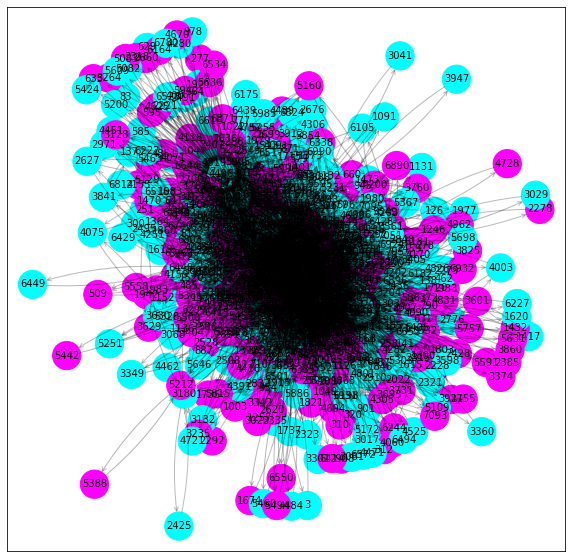

In [ ]:
# Visualize
# Colors are edge labels

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

ax, G = explainer.visualize_subgraph(node_index, data.edge_index, edge_mask, y=data.y)
plt.show()

In [ ]:
node_index = 10
node_feature_mask, edge_mask = explainer.explain_node(node_index, data.x, data.edge_index)

print()
print(node_feature_mask)
print(edge_mask)
print("Size of explanation: ", sum(edge_mask > 0))

Explain node 10: 100%|██████████| 100/100 [00:01<00:00, 78.39it/s]



tensor([0.3989, 0.2536, 0.2444, 0.7653, 0.8019, 0.7273, 0.7254, 0.2780, 0.2536,
        0.7410, 0.2599, 0.2549, 0.7850, 0.3010, 0.2858, 0.5291, 0.2812, 0.7443,
        0.2374, 0.7665, 0.4185, 0.2881, 0.5953, 0.2586, 0.7513, 0.2787, 0.7585,
        0.2667, 0.2738, 0.2505, 0.7721, 0.1850, 0.2892, 0.2840, 0.2622, 0.2684,
        0.2996, 0.2583, 0.2460, 0.2535, 0.5649, 0.7405, 0.2852, 0.2482, 0.7607,
        0.7404, 0.7589, 0.7556, 0.7277, 0.2210, 0.7568, 0.7468, 0.5547, 0.2513,
        0.2695, 0.7238, 0.7371, 0.2752, 0.5760, 0.3005, 0.7691, 0.3019, 0.2192,
        0.2562, 0.7941, 0.2712, 0.2396, 0.5339, 0.2505, 0.2293, 0.7610, 0.2331,
        0.3543, 0.2379, 0.2756, 0.3421, 0.7259, 0.7267, 0.2417, 0.2598, 0.7504,
        0.7836, 0.2474, 0.7316, 0.7581, 0.4419, 0.7588, 0.2770, 0.2928, 0.2685,
        0.7633, 0.7404, 0.2524, 0.7443, 0.2944, 0.2916, 0.3245, 0.2937, 0.7548,
        0.2684, 0.7595, 0.7361, 0.2733, 0.5006, 0.7175, 0.7568, 0.6962, 0.2773,
        0.2562, 0.2659, 0.2834, 0.7743,

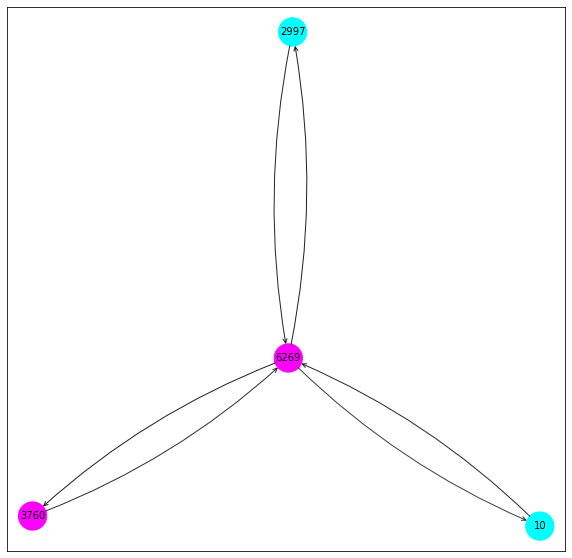

In [ ]:
ax, G = explainer.visualize_subgraph(node_index, data.edge_index, edge_mask, y=data.y)
plt.show()